In [1]:
import numpy as np
import pandas as pd

<h2> loading the embeddings

In [2]:
import pickle
with open('/kaggle/input/malware-data-ritik2000/word2vec_embeddings.pkl', 'rb') as fp:
    embed = pickle.load(fp)

In [3]:
embed['<PAD>'] = np.zeros((100))

<h2> loading the data and preprocessing

In [4]:
data = pd.read_csv('/kaggle/input/malware-data-ritik2000/malware_data.csv', index_col = 0)

In [5]:
counts_family = data.groupby('Malware Family')['Malware Family'].transform(len)
mask = (counts_family > 50)
data = data[mask]

In [6]:
for index, row in data.iterrows():
    if len(row['OpCode Sequence'].split(' ')) < 100:
        data = data.drop(index)

In [7]:
max_len = float('-inf')
for index, row in data.iterrows():
    max_len = max(max_len, len(row['OpCode Sequence'].split(' ')))

print(max_len)

27503


In [8]:
X_tokens = []
y_labels = []
for index, row in data.iterrows():
    if len(row['OpCode Sequence'].split(' ')) >= 1000:
        X_tokens.append(row['OpCode Sequence'].split(' ')[0:1000])
    else:
        X_tokens.append(row['OpCode Sequence'].split(' ') + ['<PAD>']*(1000 - len(row['OpCode Sequence'].split(' '))))
    
    y_labels.append(row['Malware Family'])

In [9]:
X = []
for row in X_tokens:
    row_embed = []
    for word in row:
        row_embed.append(embed[word])
    row_embed = np.array(row_embed)
    X.append(row_embed)

In [10]:
X = np.array(X)

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_labels)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

y = onehot_encoder.fit_transform(integer_encoded)

In [12]:
y = y.reshape(8040, 1, 7)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [14]:
nr_categories = len(data["Malware Family"].unique())

<h2> Some Basic Function Definitions

In [15]:
def init_orthogonal(param):
    """
    Initializes weight parameters orthogonally.
    This is a common initiailization for recurrent neural networks.
    
    Refer to this paper for an explanation of this initialization:
    https://arxiv.org/abs/1312.6120
    """
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")

    rows, cols = param.shape
    
    new_param = np.random.randn(rows, cols)
    
    if rows < cols:
        new_param = new_param.T
    
    # Compute QR factorization
    q, r = np.linalg.qr(new_param)
    
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T
    
    new_param = q
    
    return new_param

def sigmoid(x, derivative=False):
    """
    Computes the element-wise sigmoid activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return f * (1 - f)
    else: # Return the forward pass of the function at x
        return f

def tanh(x, derivative=False):
    """
    Computes the element-wise tanh activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return 1-f**2
    else: # Return the forward pass of the function at x
        return f

def softmax(x, derivative=False):
    """
    Computes the softmax for an array x.
    
    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        pass # We will not need this one
    else: # Return the forward pass of the function at x
        return f

<h2> LSTM Implementation

In [16]:
hidden_size = 100
embed_size = 100
z_size = hidden_size + embed_size 


def init_lstm(hidden_size, embed_size, z_size):
    """
    Initializes our LSTM network.
    
    Args:
     `hidden_size`: the dimensions of the hidden state
     `vocab_size`: the dimensions of our vocabulary
     `z_size`: the dimensions of the concatenated input 
    """
    # Weight matrix (forget gate)
    W_f = np.zeros((hidden_size, z_size))
    
    # Bias for forget gate
    b_f = np.zeros((hidden_size, 1))

    # Weight matrix (input gate)
    W_i = np.zeros((hidden_size, z_size))
    
    # Bias for input gate
    b_i = np.zeros((hidden_size, 1))

    # Weight matrix (candidate)
    W_g = np.zeros((hidden_size, z_size))
    
    # Bias for candidate
    b_g = np.zeros((hidden_size, 1))

    # Weight matrix of the output gate
    W_o = np.zeros((hidden_size, z_size))
    
    # Bias for output gate
    b_o = np.zeros((hidden_size, 1))

    # Weight matrix relating the hidden-state to the output
    W_v = np.zeros((nr_categories, hidden_size))
    
    # Bias for logits
    b_v = np.zeros((nr_categories, 1))
    
    # Initialize weights according to https://arxiv.org/abs/1312.6120
    W_f = init_orthogonal(W_f)
    W_i = init_orthogonal(W_i)
    W_g = init_orthogonal(W_g)
    W_o = init_orthogonal(W_o)
    W_v = init_orthogonal(W_v)

    return W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v


params = init_lstm(hidden_size=hidden_size, embed_size=embed_size, z_size=z_size)
print('W_f:', params[0].shape)
print('W_i:', params[1].shape)
print('W_g:', params[2].shape)
print('W_o:', params[3].shape)
print('W_v:', params[4].shape)
print('b_i:', params[5].shape)
print('b_g:', params[6].shape)
print('b_o:', params[7].shape)
print('b_v:', params[8].shape)

for param in params:
    assert param.ndim == 2, \
        'all parameters should be 2-dimensional '\
        '(hint: a dimension can simply have size 1)'

W_f: (100, 200)
W_i: (100, 200)
W_g: (100, 200)
W_o: (100, 200)
W_v: (7, 100)
b_i: (100, 1)
b_g: (100, 1)
b_o: (100, 1)
b_v: (100, 1)


In [17]:
from scipy import signal
def forward(inputs, h_prev, C_prev, p):
    """
    Arguments:
    x -- your input data at timestep "t", numpy array of shape (n_x, m).
    h_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    C_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    p -- python list containing:
                        W_f -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        b_f -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        W_i -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        b_i -- Bias of the update gate, numpy array of shape (n_a, 1)
                        W_g -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        b_g --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        W_o -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        b_o --  Bias of the output gate, numpy array of shape (n_a, 1)
                        W_v -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_v, n_a)
                        b_v -- Bias relating the hidden-state to the output, numpy array of shape (n_v, 1)
    Returns:
    z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s -- lists of size m containing the computations in each forward pass
    outputs -- prediction at timestep "t", numpy array of shape (n_v, m)
    """
    assert h_prev.shape == (hidden_size, 1)
    assert C_prev.shape == (hidden_size, 1)

    # First we unpack our parameters
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p
    
    # Save a list of computations for each of the components in the LSTM
    x_s, z_s, f_s, i_s,  = [], [] ,[], []
    g_s, C_s, o_s, h_s = [], [] ,[], []
    v_s, output_s =  [], [] 
    
    # Append the initial cell and hidden state to their respective lists
    h_s.append(h_prev)
    C_s.append(C_prev)
    
    for x in inputs:
        x = x.reshape(100, 1)
        # Concatenate input and hidden state
        z = np.row_stack((h_prev, x))
        z_s.append(z)
        
        # Calculate forget gate
        f = softmax(np.dot(W_f, z) + b_f)
        f_s.append(f)
        
        # Calculate input gate
        i = softmax(np.dot(W_i, z) + b_i)
        i_s.append(i)
        
        # Calculate candidate
        g = tanh(np.dot(W_g, z) + b_g)
        g_s.append(g)
        
        # Calculate memory state
        C_prev = np.multiply(C_prev, f) + np.multiply(g, i)
        C_s.append(C_prev)
        
        # Calculate output gate
        o = softmax(np.dot(W_o, z) + b_o)
        o_s.append(o)
        
        # Calculate hidden state
        h_prev = o * tanh(C_prev)
        h_s.append(h_prev)

        # Calculate logits
        v = np.dot(W_v, h_prev) + b_v
        v_s.append(v)
        
        # Calculate softmax
        output = softmax(v)
        output_s.append(output.reshape(1, 7))
    
    output_s = np.array(output_s)

    return z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, output_s[-1]


# Get first sentence in test set
inputs, targets = X_train[0], y_train[0]

# Initialize hidden state as zeros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Forward pass
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs, h, c, params)

print('expected output: ')
print(y_train[0])

print('predicted output: ')
print(outputs)

expected output: 
[[0. 0. 0. 0. 1. 0. 0.]]
predicted output: 
[[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714]]


In [18]:
def clip_gradient_norm(grads, max_norm=0.25):
    """
    Clips gradients to have a maximum norm of `max_norm`.
    This is to prevent the exploding gradients problem.
    """ 
    # Set the maximum of the norm to be of type float
    max_norm = float(max_norm)
    total_norm = 0
    
    # Calculate the L2 norm squared for each gradient and add them to the total norm
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm
    
    total_norm = np.sqrt(total_norm)
    
    # Calculate clipping coeficient
    clip_coef = max_norm / (total_norm + 1e-6)
    
    # If the total norm is larger than the maximum allowable norm, then clip the gradient
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    
    return grads

In [19]:
def backward(z, f, i, g, C, o, h, v, outputs, targets, p = params):
    """
    Arguments:
    z -- your concatenated input data  as a list of size m.
    f -- your forget gate computations as a list of size m.
    i -- your input gate computations as a list of size m.
    g -- your candidate computations as a list of size m.
    C -- your Cell states as a list of size m+1.
    o -- your output gate computations as a list of size m.
    h -- your Hidden state computations as a list of size m+1.
    v -- your logit computations as a list of size m.
    outputs -- your outputs as a list of size m.
    targets -- your targets as a list of size m.
    p -- python list containing:
                        W_f -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        b_f -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        W_i -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        b_i -- Bias of the update gate, numpy array of shape (n_a, 1)
                        W_g -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        b_g --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        W_o -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        b_o --  Bias of the output gate, numpy array of shape (n_a, 1)
                        W_v -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_v, n_a)
                        b_v -- Bias relating the hidden-state to the output, numpy array of shape (n_v, 1)
    Returns:
    loss -- crossentropy loss for all elements in output
    grads -- lists of gradients of every element in p
    """

    # Unpack parameters
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p

    # Initialize gradients as zero
    W_f_d = np.zeros_like(W_f)
    b_f_d = np.zeros_like(b_f)

    W_i_d = np.zeros_like(W_i)
    b_i_d = np.zeros_like(b_i)

    W_g_d = np.zeros_like(W_g)
    b_g_d = np.zeros_like(b_g)

    W_o_d = np.zeros_like(W_o)
    b_o_d = np.zeros_like(b_o)

    W_v_d = np.zeros_like(W_v)
    b_v_d = np.zeros_like(b_v)
    
    # Set the next cell and hidden state equal to zero
    dh_next = np.zeros_like(h[0])
    dC_next = np.zeros_like(C[0])
        
    # Track loss
    loss = 0
    
    for t in reversed(range(len(outputs))):
        
        # Compute the cross entropy
        loss += -np.mean(np.log(outputs[t]) * targets[t])
        # Get the previous hidden cell state
        C_prev= C[t-1]
        
        # Compute the derivative of the relation of the hidden-state to the output gate
        dv = np.copy(outputs[t])
        dv[np.argmax(targets[t])] -= 1
        dv = dv.reshape(7, 1)

        # Update the gradient of the relation of the hidden-state to the output gate
        W_v_d += np.dot(dv, h[t].T)
        b_v_d += dv

        # Compute the derivative of the hidden state and output gate
        dh = np.dot(W_v.T, dv)        
        dh += dh_next
        do = dh * tanh(C[t])
        do = sigmoid(o[t], derivative=True)*do
        
        # Update the gradients with respect to the output gate
        W_o_d += np.dot(do, z[t].T)
        b_o_d += do

        # Compute the derivative of the cell state and candidate g
        dC = np.copy(dC_next)
        dC += dh * o[t] * tanh(tanh(C[t]), derivative=True)
        dg = dC * i[t]
        dg = tanh(g[t], derivative=True) * dg
        
        # Update the gradients with respect to the candidate
        W_g_d += np.dot(dg, z[t].T)
        b_g_d += dg

        # Compute the derivative of the input gate and update its gradients
        di = dC * g[t]
        di = sigmoid(i[t], True) * di
        W_i_d += np.dot(di, z[t].T)
        b_i_d += di

        # Compute the derivative of the forget gate and update its gradients
        df = dC * C_prev
        df = sigmoid(f[t]) * df
        W_f_d += np.dot(df, z[t].T)
        b_f_d += df

        # Compute the derivative of the input and update the gradients of the previous hidden and cell state
        dz = (np.dot(W_f.T, df)
             + np.dot(W_i.T, di)
             + np.dot(W_g.T, dg)
             + np.dot(W_o.T, do))
        dh_prev = dz[:hidden_size, :]
        dC_prev = f[t] * dC
        
    grads= W_f_d, W_i_d, W_g_d, W_o_d, W_v_d, b_f_d, b_i_d, b_g_d, b_o_d, b_v_d
    
    # Clip gradients
    grads = clip_gradient_norm(grads)
    
    return loss, grads


# Perform a backward pass
loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets, params)

print('We get a loss of:')
print(loss)

We get a loss of:
0.2779871641507604


In [20]:
def update_parameters(params, grads, lr=1e-3):
    # Take a step
    for param, grad in zip(params, grads):
        param -= lr * grad
    
    return params

In [21]:
from tqdm.notebook import trange, tqdm
import tensorflow as tf
# Hyper-parameters
num_epochs = 10

# Initialize a new network
hidden_size = 100
embed_size = 100
z_size = hidden_size + embed_size 
params = init_lstm(hidden_size=hidden_size, embed_size=embed_size, z_size=z_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in trange(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    # For each sentence in validation set
    for j in tqdm(range(len(X_test))):
        
        inputs = X_test[j]
        targets = y_test[j]
        
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward pass
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs, h, c, params)
        
        # Backward pass
        loss, _ = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets, params)
        
        # Update loss
        epoch_validation_loss += loss
    
    # For each sentence in training set
    for j in tqdm(range(len(X_train))):
        
        inputs = X_train[j]
        targets = y_train[j]

        # Initialize hidden state and cell state as zeros
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward pass
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs, h, c, params)
        
        # Backward pass
        loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets, params)
        
        # Update parameters
        params = update_parameters(params, grads, lr=1e-1)
        
        # Update loss
        epoch_training_loss += loss
                
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(X_train))
    validation_loss.append(epoch_validation_loss/len(X_test))

    print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')



# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1608 [00:00<?, ?it/s]

  0%|          | 0/6432 [00:00<?, ?it/s]

Epoch 0, training loss: 0.2045929714300283, validation loss: 0.27798819033333777


  0%|          | 0/1608 [00:00<?, ?it/s]

  0%|          | 0/6432 [00:00<?, ?it/s]

Epoch 1, training loss: 0.2028890110682737, validation loss: 0.1947203256054762


  0%|          | 0/1608 [00:00<?, ?it/s]

  0%|          | 0/6432 [00:00<?, ?it/s]

Epoch 2, training loss: 0.20291825947245815, validation loss: 0.19481812051635575


  0%|          | 0/1608 [00:00<?, ?it/s]

  0%|          | 0/6432 [00:00<?, ?it/s]

Epoch 3, training loss: 0.20292141295972888, validation loss: 0.19482645836228518


  0%|          | 0/1608 [00:00<?, ?it/s]

  0%|          | 0/6432 [00:00<?, ?it/s]

Epoch 4, training loss: 0.20291672080251996, validation loss: 0.19482526256008093


  0%|          | 0/1608 [00:00<?, ?it/s]

  0%|          | 0/6432 [00:00<?, ?it/s]

Epoch 5, training loss: 0.20290045393834608, validation loss: 0.19482173453884846


  0%|          | 0/1608 [00:00<?, ?it/s]

  0%|          | 0/6432 [00:00<?, ?it/s]

Epoch 6, training loss: 0.20288345969266272, validation loss: 0.19481199074818809


  0%|          | 0/1608 [00:00<?, ?it/s]

  0%|          | 0/6432 [00:00<?, ?it/s]

Epoch 7, training loss: 0.20287814525260772, validation loss: 0.19480559481858986


  0%|          | 0/1608 [00:00<?, ?it/s]

  0%|          | 0/6432 [00:00<?, ?it/s]

Epoch 8, training loss: 0.20287679221643568, validation loss: 0.19480354701055916


  0%|          | 0/1608 [00:00<?, ?it/s]

  0%|          | 0/6432 [00:00<?, ?it/s]

Epoch 9, training loss: 0.2028764601927529, validation loss: 0.1948033378202266


NameError: name 'plt' is not defined

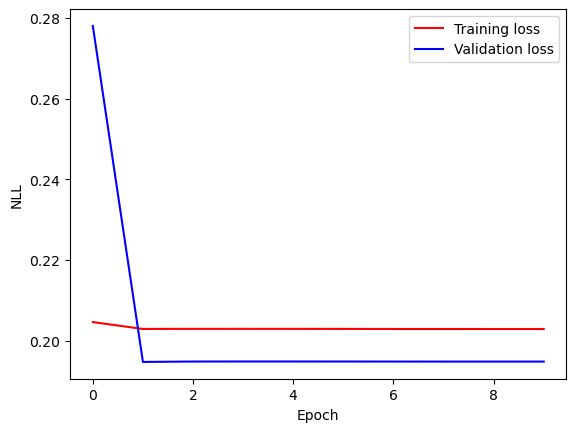

In [23]:
import matplotlib.pyplot as plt

epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

In [24]:
predicted_outputs = []
for j in tqdm(range(len(X_test))):
        
        inputs = X_test[j]
        targets = y_test[j]
        
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward pass
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs, h, c, params)
        predicted_outputs.append(outputs)

  0%|          | 0/1608 [00:00<?, ?it/s]

In [48]:
predicted_output_class = []
for output in predicted_outputs:
    class_index = np.argmax(output)
    predicted_output_class.append(class_index)

In [50]:
actual_output_class = []
for output in y_test:
    class_index = np.argmax(output)
    actual_output_class.append(class_index)

In [41]:
y_test[1400]

array([[0., 0., 0., 0., 0., 1., 0.]])

In [51]:
from sklearn.metrics import accuracy_score

accuracy_score(actual_output_class, predicted_output_class)

0.5373134328358209